# Example 6: Solving Partial Differential Equation (PDE)

We aim to solve a 2D poisson equation $\nabla^2 f(x,y) = -2\pi^2{\rm sin}(\pi x){\rm sin}(\pi y)$, with boundary condition $f(-1,y)=f(1,y)=f(x,-1)=f(x,1)=0$. The ground truth solution is $f(x,y)={\rm sin}(\pi x){\rm sin}(\pi y)$.

In [1]:
from kan import KAN, LBFGS
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm

dim = 2
np_i = 21 # number of interior points (along each dimension)
np_b = 21 # number of boundary points (along each dimension)
ranges = [-1, 1]

model = KAN(width=[2,2,1], grid=5, k=3, grid_eps=1.0, noise_scale_base=0.25)

def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

# define solution
sol_fun = lambda x: torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])
source_fun = lambda x: -2*torch.pi**2 * torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])

# interior
sampling_mode = 'random' # 'random' or 'mesh'

x_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
y_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")
if sampling_mode == 'mesh':
    #mesh
    x_i = torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
else:
    #random
    x_i = torch.rand((np_i**2,2))*2-1

# boundary, 4 sides
helper = lambda X, Y: torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:,0], Y[:,0])
xb4 = helper(X[:,0], Y[:,-1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0)

steps = 20
alpha = 0.1
log = 1

def train():
    optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    pbar = tqdm(range(steps), desc='description')

    for _ in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()
            # interior loss
            sol = sol_fun(x_i)
            sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:,0,:]
            sol_D1 = sol_D1_fun(x_i)
            sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:,:,:]
            lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
            source = source_fun(x_i)
            pde_loss = torch.mean((lap - source)**2)

            # boundary loss
            bc_true = sol_fun(x_b)
            bc_pred = model(x_b)
            bc_loss = torch.mean((bc_pred-bc_true)**2)

            loss = alpha * pde_loss + bc_loss
            loss.backward()
            return loss

        if _ % 5 == 0 and _ < 50:
            model.update_grid_from_samples(x_i)

        optimizer.step(closure)
        sol = sol_fun(x_i)
        loss = alpha * pde_loss + bc_loss
        l2 = torch.mean((model(x_i) - sol)**2)

        if _ % log == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.detach().numpy()))

train()

pde loss: 5.92e+00 | bc loss: 7.98e-02 | l2: 3.07e-02 : 100%|█| 20/20 [00:18<00:


Plot the trained KAN

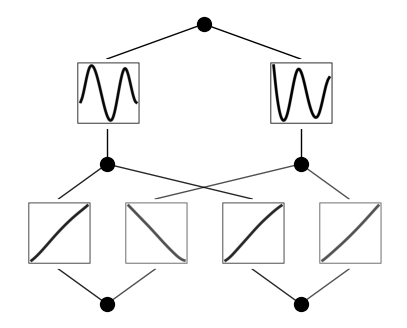

In [2]:
model.plot(beta=10)

Fix the first layer activation to be linear function, and the second layer to be sine functions (caveat: this is quite sensitive to hypreparams)

In [3]:
for i in range(2):
    for j in range(2):
        model.fix_symbolic(0,i,j,'x')
        
for i in range(2):
    model.fix_symbolic(1,i,0,'sin')

Best value at boundary.
r2 is 0.9969676978399866
Best value at boundary.
r2 is 0.9983639008937205
Best value at boundary.
r2 is 0.9974491732032462
Best value at boundary.
r2 is 0.9978791881996706
r2 is 0.9723468700787765
r2 is 0.9844055428126749


After setting all to be symbolic, we further train the model (affine parameters are still trainable). The model can now reach machine precision!

In [4]:
train()

pde loss: 1.37e-16 | bc loss: 3.89e-18 | l2: 7.38e-18 : 100%|█| 20/20 [00:07<00:


Print out the symbolic formula

In [6]:
formula, var = model.symbolic_formula(floating_digit=5)
formula[0]

0.5*sin(3.14159*x_1 - 3.14159*x_2 + 7.85398) - 0.5*sin(3.14159*x_1 + 3.14159*x_2 + 1.5708)